# Ripple NRTidal verification notebook

In [917]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt, PI
from ripple.utils_tidal import get_quadparam_octparam
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

import lalsimulation as lalsim
import lal

from ripple import get_eff_pads

%load_ext autoreload
%autoreload 2
from ripple.waveforms import X_NRTidalv2

params = {"axes.grid": True,
          "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)


jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

In [918]:
m1 = 3.703185
m2 = 2 #3.290031

chi1 = 1 #0.865366	
chi2 = 1 #0.987117	

lambda1 = 5000 # 1268.527046
# lambda2 = 10 # 21.333623
lambda2 = lambda1

distance = 440.

Get the frequency grid:

In [919]:
# Frequency grid
T = 16
f_l = 20.0
f_sampling = 2 * 2048
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
# df = 0.01
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [920]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = np.pi / 2
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs_ripple, theta_ripple, f_ref)

[2.34714409e+00 2.27703909e-01 1.00000000e+00 1.00000000e+00
 4.40000000e+02 0.00000000e+00 0.00000000e+00]
Kappa
1138.3917586008743
[-1.00228664e-23+4.11725016e-24j  6.22147506e-24-8.82330653e-24j
  1.37130343e-24+1.06692878e-23j ... -4.48351059e-26-3.61508705e-26j
 -4.48187671e-26-3.61689739e-26j -4.48024220e-26-3.61870690e-26j]
BBH results
[1.08355710e-23 1.07961794e-23 1.07570523e-23 ... 5.75940288e-26
 5.75926780e-26 5.75913273e-26]
[-2.75182298+0.00000000e+00j  0.9566435 +2.22044605e-16j
 -1.44296902+0.00000000e+00j ...  2.46301765+0.00000000e+00j
  2.46259488+0.00000000e+00j  2.46217213-1.11022302e-16j]
Amp0
5.4954281237395396e-27
Tidal amplitude
[-1.04401825e-28 -1.05127014e-28 -1.05855030e-28 ... -1.47882114e-24
 -1.47888468e-24 -1.47894822e-24]
quadparams
11.87055026549859 11.87055026549859
octparams
25.323683677497282 25.323683677497282
Higher order spin correction prefactor
-7439.312387447255 -556.9509494519439
Psi tidal
[-3.26115167e-01 -3.27831177e-01 -3.29550896e-01 ... 

In [921]:
test_low = get_quadparam_octparam(0)
print(test_low)
test_high = get_quadparam_octparam(350)
print(test_high)

(Array(1., dtype=float64, weak_type=True), Array(1.00313591, dtype=float64, weak_type=True))
(Array(5.29978493, dtype=float64, weak_type=True), Array(10.50542645, dtype=float64, weak_type=True))


## LAL

In [922]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
# print(quad1)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# print(oct1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)

0

In [923]:
IMRphenom = "IMRPhenomD_NRTidalv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

In [924]:
hp_lalsuite

array([-3.33394931e-24+4.27043504e-24j, -1.07032197e-24-5.29086148e-24j,
        5.07983279e-24+1.76727826e-24j, ...,
       -0.00000000e+00+0.00000000e+00j, -0.00000000e+00+0.00000000e+00j,
       -0.00000000e+00+0.00000000e+00j])

## Comparison

In [925]:
# One frequency variable, just f
f = freqs_lal[mask_lal]

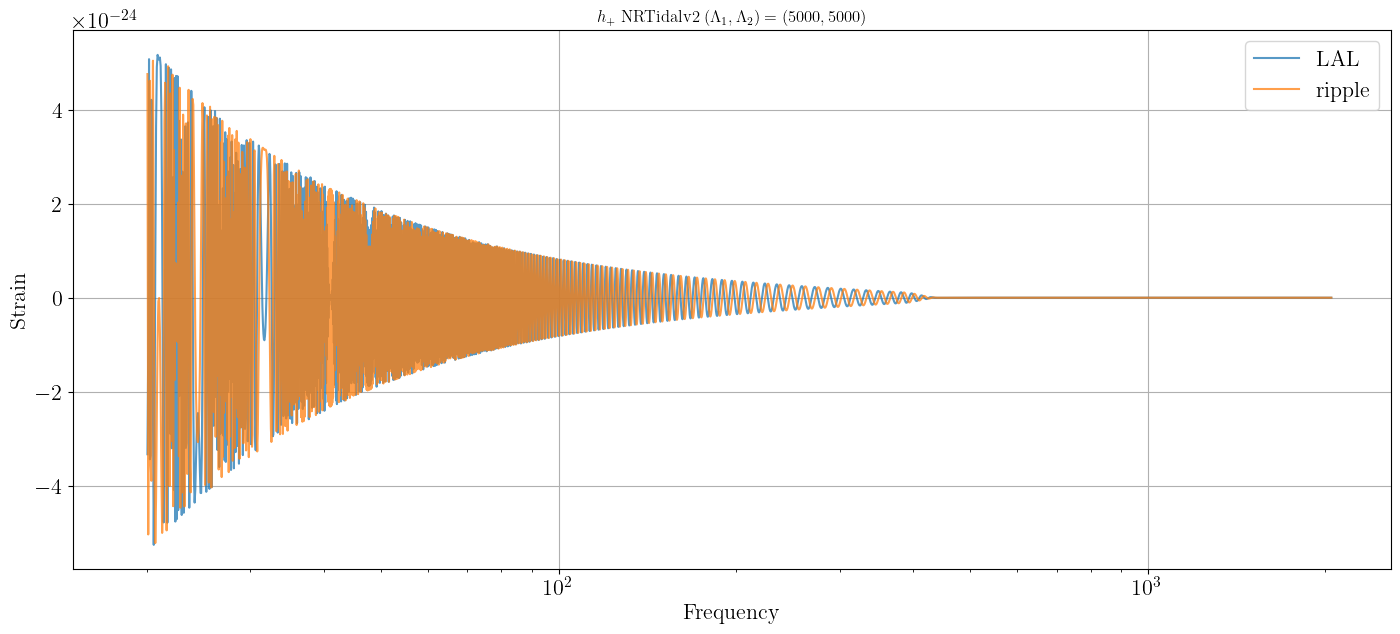

In [926]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

My kappa: 1138.391758600875
Frequency merger:  376.9664231587967
Frequency merger LAL 376.96642912095456
Lal kappa: 1138.3917586008743


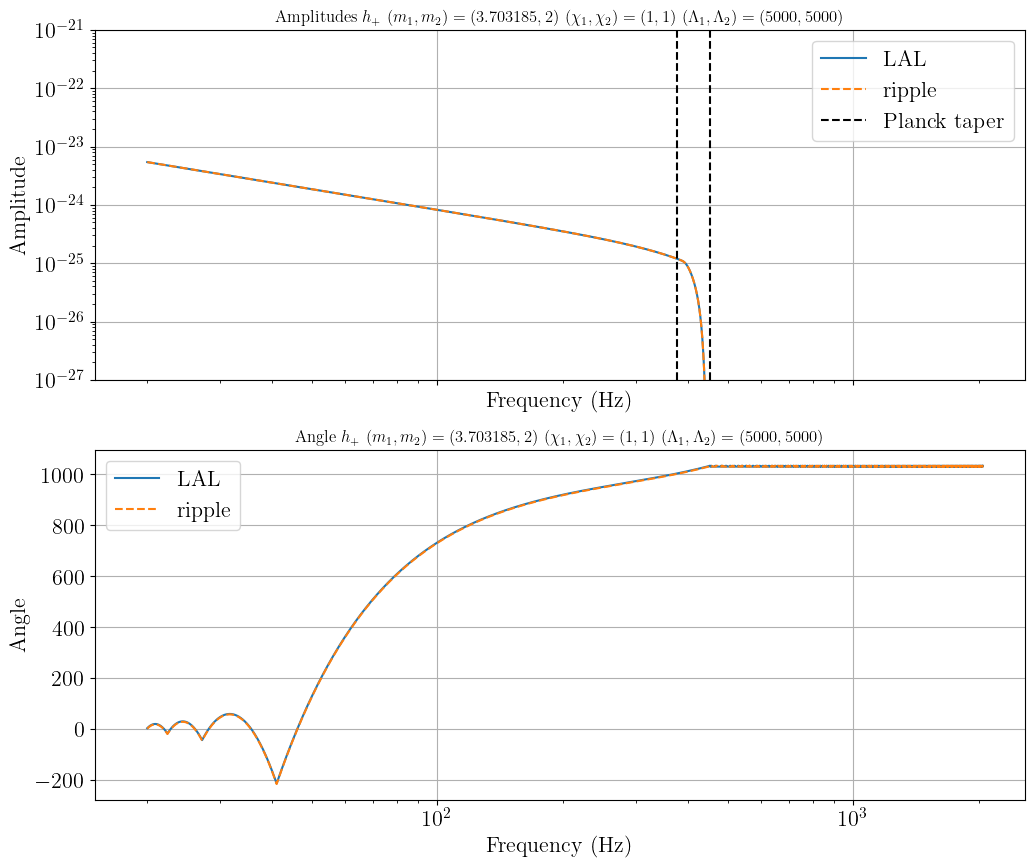

In [927]:
## Get the merger frequency to check the Planck taper window

l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])
print(f"My kappa: {X_NRTidalv2.get_kappa(merger_params)}")

f_merger = X_NRTidalv2._get_merger_frequency(merger_params)
f_merger = float(f_merger)

# print("Merger params (m1, m2, chi1, chi2, lambda1, lambda2): ", merger_params)
print("Frequency merger: ", f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')


lal_kappa = lalsim.SimNRTunedTidesComputeKappa2T(m1, m2, l1, l2)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), lal_kappa, m1/m2)
print(f"Frequency merger LAL {lal_f_merger}")

# Kappas
print(f"Lal kappa: {lal_kappa}")

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

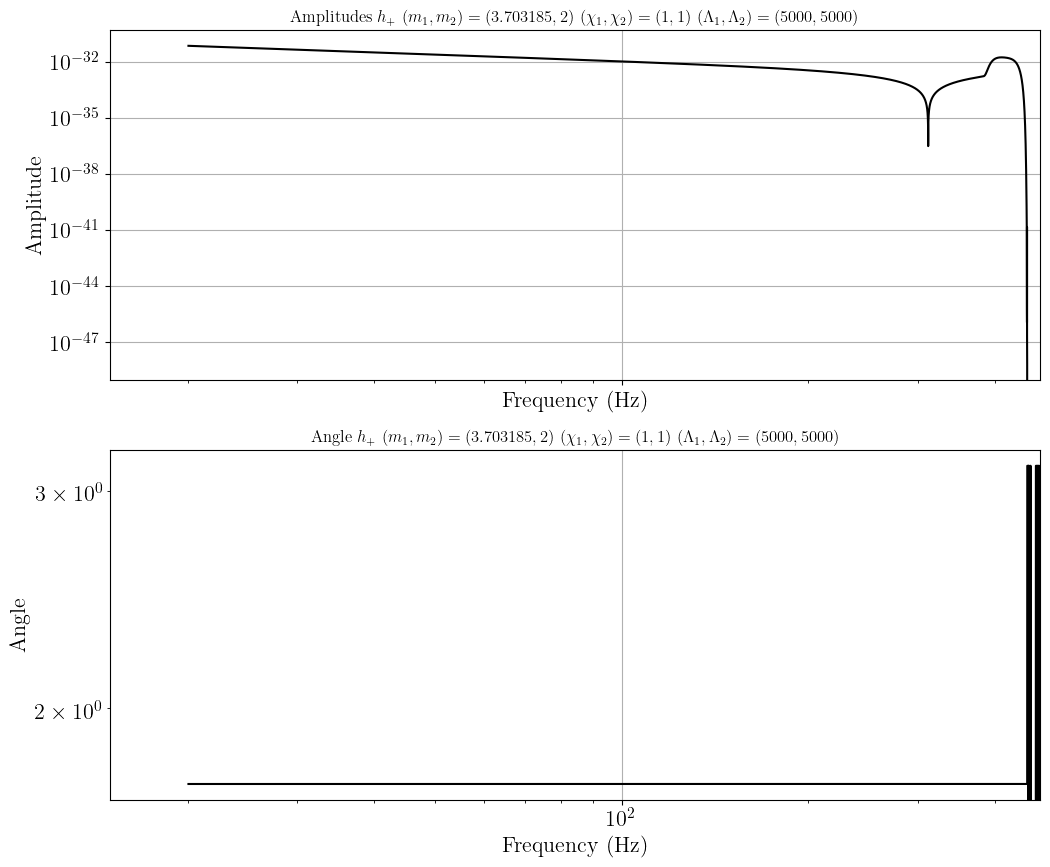

In [928]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.yscale('log')
plt.show()

## Computing mismatch

In [929]:
from ripple import get_match_arr

In [930]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_ripple,
        hp_lalsuite,
    )

print(match)
print(np.log10(1 - match))

0.9999999998840714
-9.935809408618706


## Debugging

Checking if computations match very precisely

In [931]:
print("LAL quad and oct")
print(quad1)
print(oct1)

print("Ripple quad and oct")
quad, oct = get_quadparam_octparam(lambda1)
print(quad)
print(oct)

print("Absolute differences")
print(abs(quad - quad1))
print(abs(oct - oct1))

print("LAL kappa")
kappa_lal = lalsim.SimNRTunedTidesComputeKappa2T(m1_kg, m2_kg, lambda1, lambda2)
print(kappa_lal)

print("Ripple kappa")
kappa_ripple = X_NRTidalv2.get_kappa(jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))
print(kappa_ripple)

print("Absolute differences")
print(abs(kappa_lal - kappa_ripple))

print("LAL f merger")
f_merger_lal = lalsim.SimNRTunedTidesMergerFrequency(m1+m2, kappa_lal, m1/m2)
print(f_merger_lal)

print("Ripple f merger")
f_merger_ripple = X_NRTidalv2._get_merger_frequency(jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))
print(f_merger_ripple)

print("Absolute differences")
print(abs(f_merger_ripple - f_merger_lal))

LAL quad and oct
11.87055026549859
25.323683677497296
Ripple quad and oct
11.87055026549859
25.323683677497282
Absolute differences
0.0
1.4210854715202004e-14
LAL kappa
1138.391758600875
Ripple kappa
1138.391758600875
Absolute differences
0.0
LAL f merger
376.9664291209544
Ripple f merger
376.9664231587967
Absolute differences
5.962157672456669e-06


In [932]:
M = m1 + m2
M_s = M * gt
test1 = lalsim.SimInspiralGetHOSpinTerms(m1/M, m2/M, chi1, chi2, quad1, quad2)

In [933]:
test1

[-7439.312387447256, -556.9509494519449]

In [934]:
x = (PI * M_s * f) ** (2.0/3.0)
test = X_NRTidalv2.get_spin_phase_correction(x, jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))

quadparams
11.87055026549859 11.87055026549859
octparams
25.323683677497282 25.323683677497282
Higher order spin correction prefactor
-7439.312387447253 -556.9509494519438
